In [ ]:
from nelson_siegel_svensson import NelsonSiegelSvenssonCurve
import numpy as np
from matplotlib.pyplot import plot
import pandas as pd
from pathlib import Path
from scipy import stats

"""
Generates the yields for specific points in the curve -> tenors,
provided curve parameters previously calculated, 
removing outliers through z-score threshold
Merges dataset and produces dictionary separating data by curve sector 
"""
local_drive = Path('C:/Users/torin/OneDrive')
file_path = Path('Desktop/Thesis/notebooks/matlab')
datapath = (local_drive / file_path)

def read_data(filename, datapath):
    params = pd.read_csv(datapath / filename)[1:]
    params['params7'] = pd.to_datetime(params['params7'])
    params = params.set_index(['params7']).T
    return params

def generate_array(params, col, country, tenors):
    # [Beta0,Beta1,Beta2,Beta3,tau1,tau2]
    Beta0, Beta1, Beta2, Beta3, tau1, tau2= params[0],params[1],params[2],params[3],params[4],params[5]
    y = NelsonSiegelSvenssonCurve(Beta0, Beta1, Beta2, Beta3, tau1, tau2)
    t = np.array(tenors)
    res = pd.DataFrame({'tenor':t,'yield':y(t),'date':[col]*len(t)})
    res['country'] = country
    return res

def generate_results(params_frame, tenors, country):
    list_results = []
    for col in params_frame.columns:
        list_results.append(
            generate_array(
                np.asarray(params_frame[col]), col, country, tenors
                )
                )
    return list_results

def remove_outliers(df, threshold_z, tenors):
    dflist= []
    for year in tenors:
        dfs = df[df['tenor'] == year]
        dfs['z'] = np.abs(stats.zscore(dfs['yield']))
        dfs = dfs[dfs['z'] < threshold_z]
        del dfs['z']
        dflist.append(dfs)
    df_no_outliers = pd.concat(dflist)
    return df_no_outliers

def generate_curve_dataframe(filename, country, datapath, threshold_z, tenors):
    df = read_data(filename, datapath)
    list_results = generate_results(df, tenors, country)
    par_yield = pd.concat(list_results)
    par_yield = remove_outliers(par_yield, threshold_z, tenors)
    return par_yield

def return_sectors(par_yield_curves, year):
    sector = par_yield_curves[par_yield_curves['tenor'] == year]
    return sector

def return_spread(country_list, ref_country, sectordf):
    spread = sectordf.pivot(index = ['tenor', 'date'], values = ['yield'], columns = ['country']).reset_index()
    spread.columns = [' '.join(col).strip() for col in spread.columns.values]
    country_list = [x for x in country_list if x != ref_country]
    for c in country_list:
        spread['spread_' + ref_country + '_' + c ] = spread['yield '+ ref_country] - spread['yield '+ c] 
    return spread

## parameters
threshold_z=1.5
tenors=[2,3,4,5,6,7,8,10,12,15,20,25,30]

## file_map
file_map = {'IT':'IT_Svensson.csv',
            'BR':'BR_Svensson.csv'}

yield_curves = []

refcountry = 'BR'


In [ ]:

for country,filename in file_map.items():
    yield_curves.append(
        generate_curve_dataframe(filename,
                                         country,
                                         datapath,
                                         threshold_z,
                                         tenors)
                                         )
    
par_yield_curves = pd.concat(yield_curves)

sectors = dict.fromkeys(tenors, '')
for year in tenors:
    sectors[year] = return_sectors(par_yield_curves,year)


In [35]:

sector_spreads = dict.fromkeys(tenors, '')
for year in tenors:
    sector_spreads[year] = return_spread(
        list(file_map.keys()), 
        refcountry,
        return_sectors(par_yield_curves,year)
        )
    # cross-equation coveriance error term
    # in each case error terms are gaussian
    # what are they picking up

    # unobservable errors are correlated
    # seemingly unrelated estimator


In [ ]:

monhtly_sector_spreads = dict.fromkeys(tenors, '')
for year, df in sector_spreads.items():
    monhtly_sector_spreads[year] = df.dropna(subset = ['spread_BR_IT'])

<Axes: xlabel='date'>

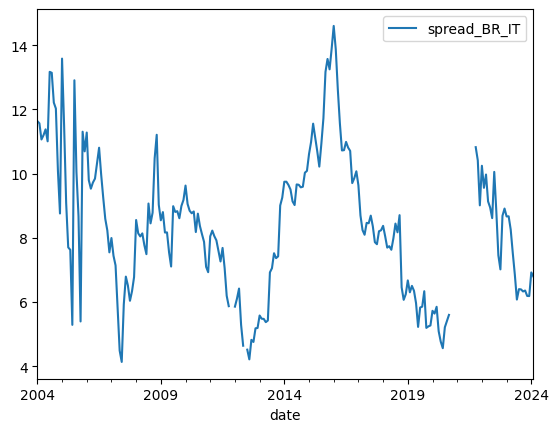

In [51]:
sector_spreads[5].dropna(subset = ['spread_BR_IT']).set_index(['date']).resample('MS').mean()[['spread_BR_IT']].plot()

In [57]:
temp = sector_spreads[5].dropna(subset = ['spread_BR_IT']).set_index(['date']).resample('MS').mean()
temp[temp.index.year == 2020]

,tenor,yield BR,yield IT,spread_BR_IT
date,,,,
2020-01-01,5.0,6.370003,0.642268,5.727735
2020-02-01,5.0,6.115469,0.473853,5.641616
2020-03-01,5.0,6.859424,1.005814,5.853610
2020-04-01,5.0,6.330057,1.238968,5.091089
2020-05-01,5.0,5.971922,1.203149,4.768773
2020-06-01,5.0,5.360424,0.797208,4.563215
2020-07-01,5.0,5.813829,0.598558,5.215270
2020-08-01,5.0,5.848717,0.439328,5.409389
2020-09-01,5.0,6.046209,0.445962,5.600247


In [58]:
sector_spreads[5][sector_spreads[5].date.dt.year == 2020]

,tenor,date,yield BR,yield IT,spread_BR_IT
4628,5,2020-01-01,NaN,0.650110,NaN
4629,5,2020-01-02,6.411991,0.660462,5.751530
4630,5,2020-01-03,6.455674,0.606155,5.849519
4631,5,2020-01-06,6.419764,0.621049,5.798715
4632,5,2020-01-07,6.449817,0.642959,5.806858
...,...,...,...,...,...
4878,5,2020-12-22,5.742612,NaN,NaN
4879,5,2020-12-23,5.647565,NaN,NaN
4880,5,2020-12-28,5.579676,NaN,NaN
4881,5,2020-12-29,5.521877,NaN,NaN
